In [3]:
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy.constants import c
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
import array_to_latex as a2l
import csv
import pandas as pd
import sympy as sym
import fprlib as fp
import glob

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) #font na grafih je LaTexov
rc('text', usetex=True)

#x,y = np.loadtxt('osciloskop_meritve.csv', delimiter=',', skiprows=1, unpack=True)

"""
# Grafiranje:

fig, ax = plt.subplots()

ax.plot(x, y, c="darkblue", ls="-", lw=0.5, label=r"Napetost na vezju")
ax.plot([-0.07,0.07], [32,32],c="r", ls="-", lw=0.4, label=r"32 V napetost")
ax.grid(True, which="both")
plt.xlabel(r"Čas [s]")
plt.ylabel(r"Amplituda [V]")
plt.legend(loc='best')
#ax.set_ylim([-1, 1])
ax.set_xlim([-0.00005, 0.0007])
plt.title("Začetno odstopanje napetosti skozi vezje tuljave")
fig.show()
fig.savefig("start_impulse", dpi=600, bbox_inches='tight', transparent=False)
"""
print("...") # Narejeno da ne izpiše celotnega block comment-a zgoraj \lol

...


In [557]:
ε_0 = 8.854e-12
g = 9.80665
R, ΔR = 5e9, 0.1e9
S, ΔS = np.pi * (38e-3/2)**2, np.pi * 2*(38e-3/2) * 0.2e-3/2
b, Δb = 6.5e-3, 0.2e-3
m_2, m_3, m_1, Δm = 194e-3, 500.13e-3, 1000.10e-3, 1e-5

In [559]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./meritve')
meas_dict = {}
for fname in os.listdir(meas_dir):
    if fname!=b'.ipynb_checkpoints':
        with open(os.path.join(meas_dir, fname)) as file:
            meas = [[float(el) for el in row.rstrip('\t').split(",")]
                for row in file.readlines()[12:]]
            meas_name = os.fsdecode(fname).removesuffix('.txt')
            meas_dict[meas_name] = np.array(meas).T

In [560]:
def crop(arr, α, β):
    N = len(arr)
    return arr[int(α*N):int(β*N)]

def U_ansatz(t, U_0, τ):
    return U_0 * np.exp(-t/τ)

In [563]:
1e4 * S, 1e4 * ΔS

(11.341149479459153, 0.11938052083641214)

In [565]:
def process_meas(meas_name, α, β):
    meas = meas_dict[meas_name]
    t_raw, U_raw = meas[:,:-100:100]/1.71
    U_base = np.mean(crop(U_raw, 0, α))
    σU_base = np.std(crop(U_raw, 0, α))
    U = U_raw - U_base
    t = t_raw - t_raw[np.argmax(-U_raw)]

    # Plot.
    fig, ax = plt.subplots(1, 1, figsize=[6, 4])

    # Plot measurements.
    #ax.plot(crop(t, 0, α), crop(U, 0, α), color='seagreen', alpha=0.5, label='meritev')
    ax.plot(crop(t, 0, β), crop(U, 0, β), color='lightsalmon', label='izključeno')
    ax.plot(crop(t, β, 1), crop(U, β, 1), color='seagreen', alpha=0.5)

    # Fit and calculate C and ε.
    par, cov = curve_fit(U_ansatz, crop(t, β, 1), crop(-U, β, 1))
    U_0, τ = par
    σU_0, στ = np.sqrt(np.diag(cov))
    ΔU_0 = np.sqrt(σU_0**2 + σU_base**2)
    C = τ / R
    ΔC = np.sqrt(
        (1/R * στ)**2 +
        (-τ/R**2 * ΔR)**2
    )
    ε = C*b / (ε_0*S)
    Δε = np.sqrt(
        (1*b / (ε_0*S) * ΔC)**2 +
        (C*1 / (ε_0*S) * Δb)**2 +
        (-C*b / (ε_0 * S**2) * ΔS)**2
    )

    # Plot fitted.
    t_lin = np.linspace(np.min(crop(t, β, 1)) - 1, np.max(crop(t, β, 1)) + 1)
    ax.plot(t_lin, -U_ansatz(t_lin, U_0, τ), color='black', label='fit z repom')

    # Labels and style.
    is_rise = meas_name.split('-')[0] == 'rise'
    title_part = 'Razbremenitev' if is_rise else 'Obremenitev'
    i_to_m_dict = {1: m_1, 2: m_2, 3: m_3}
    m = i_to_m_dict[int(meas_name.split('-')[1])]
    ax.set_title(f"{title_part} s ${np.round(m*1000, 2)}\,\mathrm{{g}}$ utežjo")
    ax.set_xlabel(r'$t\,[\mathrm{s}]$')
    ax.set_ylabel(r"$\Delta U\,[\mathrm{V}]$")
    ax.grid(linestyle=':')
    ax.legend(loc='lower right')
    ax.margins(x=0.08, y=0.08)
    fig.savefig(f'{meas_name.split("-")[0]}-{1000*m:.0f}')
    return (m if is_rise else -m), U_0, ΔU_0, τ, στ, C, ΔC, ε, Δε

1000 & 0.84 & 0.01 & 9.7 & 0.0 & 1.9 & 0.0 & 1259 & 48 \\
194 & 0.16 & 0.00 & 6.9 & 0.0 & 1.4 & 0.0 & 897 & 34 \\
500 & 0.42 & 0.00 & 10.5 & 0.0 & 2.1 & 0.0 & 1356 & 52 \\
-1000 & -0.71 & 0.00 & 11.2 & 0.0 & 2.2 & 0.0 & 1451 & 55 \\
-194 & -0.53 & 0.02 & 4.2 & 0.0 & 0.8 & 0.0 & 541 & 21 \\
-500 & -0.35 & 0.13 & 4.5 & 0.0 & 0.9 & 0.0 & 586 & 22 \\


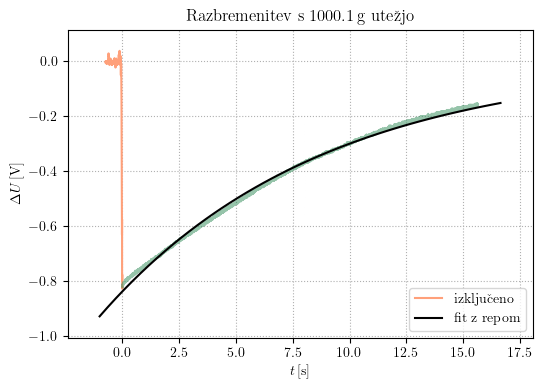

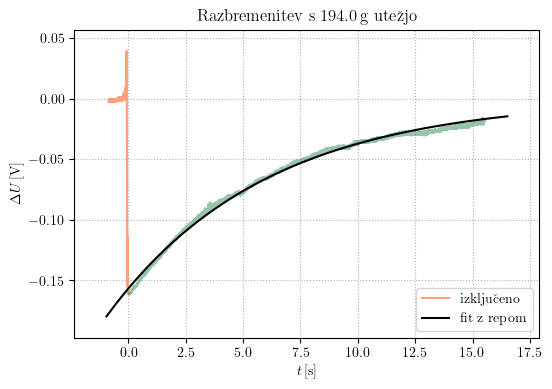

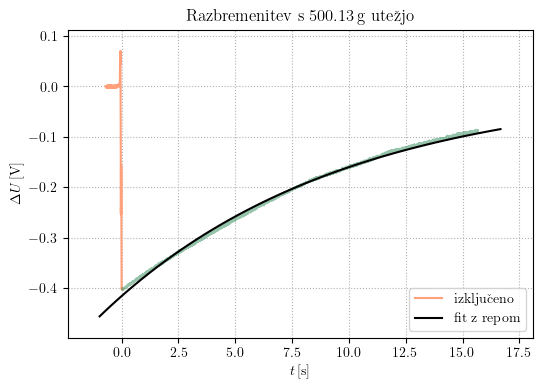

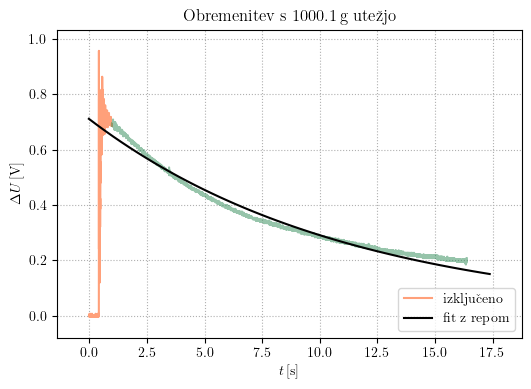

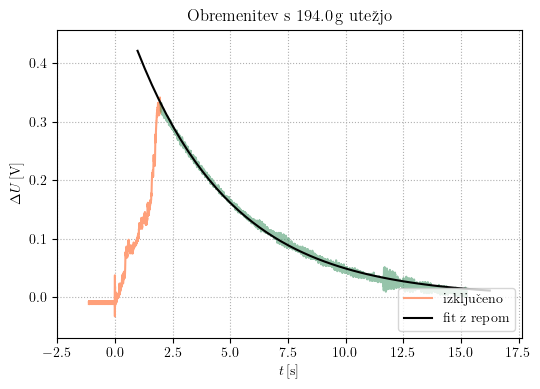

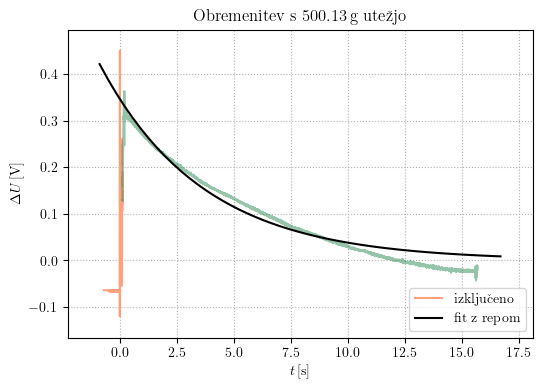

In [567]:
calc_arr = []
for meas_name, α, β in [('rise-1', 0.01, 0.045),
                        ('rise-2', 0.045, 0.055),
                        ('rise-3', 0.035, 0.045),
                        ('fall-1', 0.02, 0.06),
                        ('fall-2', 0.1, 0.19),
                        #for /1.75 or greater ('fall-3', 0.0585, 0.06)]:
                        ('fall-3', 0.0585, 0.05)]:
    calc = process_meas(meas_name, α, β)
    calc_arr.append(calc)
    m_sgn, U_0, ΔU_0, τ, στ, C, ΔC, ε, Δε = calc
    print(f'{1000*m_sgn:.0f} & {U_0:.2f} & {ΔU_0:.2f} & {τ:.1f} & {στ:.1f} & {1e9 * C:.1f} & {1e9 * ΔC:.1f} & {ε:.0f} & {Δε:.0f} \\\\')

(1.5682567821551157, 0.56013107058391, 0.245701449965162, 0.04394549804263788)

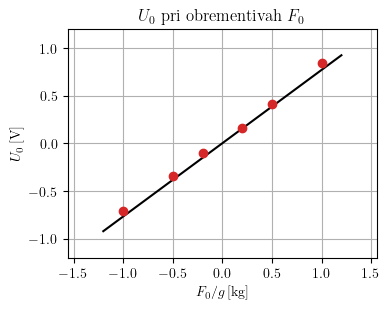

In [588]:
m_sgn, U_0, ΔU_0, τ, στ, C, ΔC, ε, Δε = np.array(calc_arr).T

U_0[4]= -0.1

par, cov = np.polyfit(m_sgn, U_0, 1, cov=True)
k, c = par
σk = np.sqrt(cov[0,0])
C_mean, σC_mean = np.mean(C), np.std(C)
d = k*C_mean/g*2
Δd = np.sqrt(
    (1*C_mean/g * σk)**2 +
    (k*1/g * σC_mean)**2
)

fig, ax = plt.subplots(1, 1, figsize=[4, 3.2])

ax.scatter(m_sgn, U_0, color='tab:red', zorder=5)
m_lin = np.linspace(-1.2, 1.2)
ax.plot(m_lin, k*m_lin, color='black', zorder=4)

ax.set_title(r'$U_0$ pri obrementivah $F_0$')
ax.set_xlabel(r'$F_0/g\,[\mathrm{kg}]$')
ax.set_ylabel(r"$U_0\,[\mathrm{V}]$")
ax.margins(x=0.15, y=0.15)
ax.grid()
fig.tight_layout()
fig.savefig('U_0-by-m')
1e9 * C_mean, 1e9 * σC_mean, 1e9 * d, 1e9 * Δd

In [585]:
ε_mean = np.mean(ε)
σε_mean = np.std(ε)
ε_mean, σε_mean

(1015.1586950155066, 362.58215690302586)